In [ ]:
# 查看当前挂载的数据集目录, 该目录下的变更重启环境后会自动还原
# View dataset directory. This directory will be recovered automatically after resetting environment. 
!ls /home/aistudio/data

In [ ]:
# 查看工作区文件, 该目录下的变更将会持久保存. 请及时清理不必要的文件, 避免加载过慢.
# View personal work directory. All changes under this directory will be kept even after reset. Please clean unnecessary files in time to speed up environment loading.
!ls /home/aistudio/work

In [ ]:
!rm -rf __MACOSX
!unzip -q /home/aistudio/data/data23617/characterData.zip

In [51]:
#导入需要的包

import numpy as np
import paddle as paddle
import paddle.fluid as fluid
from paddle.fluid import layers
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import os
from multiprocessing import cpu_count
from paddle.fluid.dygraph import Pool2D,Conv2D,BatchNorm,CosineDecay
# from paddle.fluid.dygraph import FC
from paddle.fluid.dygraph import Linear

In [ ]:
# 生成车牌字符图像列表
data_path = '/home/aistudio/data'
character_folders = os.listdir(data_path)
label = 0
LABEL_temp = {}
if(os.path.exists('./train_data.list')):
    os.remove('./train_data.list')
if(os.path.exists('./test_data.list')):
    os.remove('./test_data.list')
for character_folder in character_folders:
    with open('./train_data.list', 'a') as f_train:
        with open('./test_data.list', 'a') as f_test:
            if character_folder == '.DS_Store' or character_folder == '.ipynb_checkpoints' or character_folder == 'data23617':
                continue
            # print(character_folder + " " + str(label))
            LABEL_temp[str(label)] = character_folder #存储一下标签的对应关系
            character_imgs = os.listdir(os.path.join(data_path, character_folder))
            for i in range(len(character_imgs)):
                if i%10 == 0: 
                    f_test.write(os.path.join(os.path.join(data_path, character_folder), character_imgs[i]) + "\t" + str(label) + '\n')
                else:
                    f_train.write(os.path.join(os.path.join(data_path, character_folder), character_imgs[i]) + "\t" + str(label) + '\n')
    label = label + 1
print('图像列表已生成',label)


图像列表已生成 65


In [49]:
def mixup(X, y):
    '''
        功能：图像增强，mixup
        参数：
            X：batch imgs
            y: batch labels
        超参：
            beta: beta分布的alpha和beta参数，这个可以自己设置，并观察结果
        引用：
            mixup: Beyond Empirical Risk Minimization(https://arxiv.org/abs/1710.09412)
    '''
    mixup_alpha = 0.1
    seed = np.random.beta(mixup_alpha, mixup_alpha)
    index = np.arange(X.shape[0])
    np.random.shuffle(index)
    images_a, images_b = X, X[index]
    labels_a, labels_b = y, y[index]
    mixed_images = seed * images_a + (1 - seed) * images_b
    return mixed_images, labels_a, labels_b, seed

# 用上一步生成的图像列表定义车牌字符训练集和测试集的reader
def data_mapper(sample):
    img, label = sample
    img = paddle.dataset.image.load_image(file=img, is_color=False)
    img = img.flatten().astype('float32') / 255.0
    return img, label
def data_reader(data_list_path):
    def reader():
        with open(data_list_path, 'r') as f:
            lines = f.readlines()
            for line in lines:
                img, label = line.split('\t')
                yield img, int(label)
    return paddle.reader.xmap_readers(data_mapper, reader, cpu_count(), 10240)

In [10]:
# 用于训练的数据提供器
BATCH_SIZE = 128
train_reader = paddle.batch(reader=paddle.reader.shuffle(reader=data_reader('./train_data.list'), buf_size=51200), batch_size=BATCH_SIZE)
# 用于测试的数据提供器
test_reader = paddle.batch(reader=data_reader('./test_data.list'), batch_size=128)

In [11]:
data = next(train_reader())
data[0][0].shape, data[0][1]

((400,), 55)

In [55]:
#定义网络

# out_chs = [6, 16, 256]
# out_chs = [16, 32, 256]
# out_chs = [16, 32, 512]
out_chs = [32, 64, 256]
# out_chs = [32, 64, 1024]
class MyLeNet(fluid.dygraph.Layer):
    def __init__(self, *, channels, fig_size, num_class):
        super(MyLeNet,self).__init__()
        self.hidden1_1 = Conv2D(channels, out_chs[0], 5, padding=2)
        self.bn1 = BatchNorm(out_chs[0], act='relu')
        self.hidden1_2 = Pool2D(2, 'avg', 2)
        self.hidden2_1 = Conv2D(out_chs[0], out_chs[1], 3, padding=1)
        self.bn2 = BatchNorm(out_chs[1], act='relu')
        self.hidden2_2 = Pool2D(2, 'avg', 2)
        self.hidden3 = Conv2D(out_chs[1], out_chs[2] ,1) # 第三个卷积层用 1*1 卷积， 相当于全链接层，但是参数要少的多
        self.bn3 = BatchNorm(out_chs[2], act='relu')
        self.global_avg_pool = Pool2D(pool_type='avg', global_pooling=True)
        self.hidden4 = Linear(out_chs[2], num_class, act='softmax')
    def forward(self,input):
        x = self.bn1(self.hidden1_1(input))
        x = self.hidden1_2(x)

        x = self.bn2(self.hidden2_1(x))
        x = self.hidden2_2(x)

        x = self.bn3(self.hidden3(x))
        x = self.global_avg_pool(x)

        x = fluid.layers.flatten(x)
        y = self.hidden4(x)
        return y

In [56]:
EPOCH = 200

train_losses = []
train_accs = []
with fluid.dygraph.guard():
    model=MyLeNet(channels=1, fig_size=20, num_class=65) #模型实例化
    model.train() #训练模式
    lr = 0.1 * (BATCH_SIZE / 256)
    opt=fluid.optimizer.SGDOptimizer(learning_rate=CosineDecay(lr, EPOCH, EPOCH), parameter_list=model.parameters())#优化器选用SGD随机梯度下降，学习率为0.001.
    epochs_num= EPOCH #迭代次数为20
    
    for pass_num in range(epochs_num):
        n, train_loss, train_acc = 0, 0, 0
        for batch_id,data in enumerate(train_reader()):
            images=np.array([x[0].reshape(1,20,20) for x in data],np.float32)
            labels = np.array([x[1] for x in data]).astype('int64')
            images, labels_a, labels_b, seed = mixup(images, labels)
            labels = labels[:, np.newaxis]
            image=fluid.dygraph.to_variable(images)
            label=fluid.dygraph.to_variable(labels)
            
            predict=model(image)#预测
            
            # loss=fluid.layers.cross_entropy(predict,label)
            loss = seed * fluid.layers.cross_entropy(predict, fluid.dygraph.to_variable(labels_a)) + (1 - seed) * fluid.layers.cross_entropy(predict, fluid.dygraph.to_variable(labels_b))
            avg_loss=fluid.layers.mean(loss)#获取loss值
            
            # acc=fluid.layers.accuracy(predict,label)#计算精度
            acc = seed * fluid.layers.accuracy(predict, layers.unsqueeze(fluid.dygraph.to_variable(labels_a), axes=[1])) + (1 - seed) * fluid.layers.accuracy(predict, layers.unsqueeze(fluid.dygraph.to_variable(labels_b),axes=[1]))
            
            # if batch_id!=0 and batch_id%50==0:
            #     print("train_pass:{},batch_id:{},train_loss:{},train_acc:{}".format(pass_num,batch_id,avg_loss.numpy(),acc.numpy()))
            n += 1
            train_loss += avg_loss.numpy()
            train_acc += acc.numpy()
            avg_loss.backward()
            opt.minimize(avg_loss)
            model.clear_gradients() 
        print("train_pass:{},train_loss:{},train_acc:{}".format(pass_num,train_loss / n,train_acc / n))
        train_losses.append(train_loss / n)
        train_accs.append(train_acc / n)                   
        fluid.save_dygraph(model.state_dict(),'MyLeNet')#保存模型

train_pass:0,train_loss:[3.3812716],train_acc:[0.2556048]
train_pass:1,train_loss:[2.7262435],train_acc:[0.4184469]
train_pass:2,train_loss:[2.3208635],train_acc:[0.48316917]
train_pass:3,train_loss:[2.0308437],train_acc:[0.55498224]
train_pass:4,train_loss:[1.7814012],train_acc:[0.623728]
train_pass:5,train_loss:[1.6593231],train_acc:[0.65112936]
train_pass:6,train_loss:[1.406969],train_acc:[0.71486425]
train_pass:7,train_loss:[1.3344711],train_acc:[0.7268327]
train_pass:8,train_loss:[1.2689409],train_acc:[0.7352284]
train_pass:9,train_loss:[1.2074635],train_acc:[0.74744296]
train_pass:10,train_loss:[1.1171352],train_acc:[0.7749014]
train_pass:11,train_loss:[1.1056905],train_acc:[0.7811057]
train_pass:12,train_loss:[1.0147761],train_acc:[0.8132306]
train_pass:13,train_loss:[0.99742657],train_acc:[0.82267284]
train_pass:14,train_loss:[0.98467475],train_acc:[0.82289577]
train_pass:15,train_loss:[0.9042336],train_acc:[0.8378769]
train_pass:16,train_loss:[0.88300943],train_acc:[0.84318846

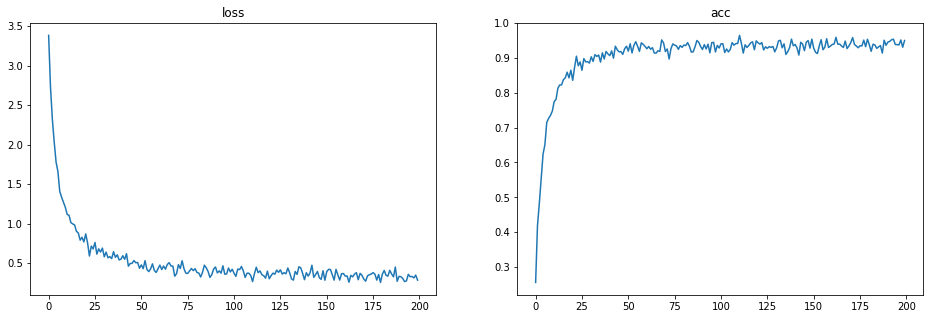

In [57]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=(16,5))
plt.subplot(121)
plt.plot(train_losses)
plt.title('loss')
plt.subplot(122)
plt.plot(train_accs)
plt.title('acc')
plt.savefig('32_64_256_mixup.png')
plt.show()

## 实验结果


| conv arch(ch_out) | data aug | acc |
| -------- | -------- | -------- |
| 6 16 256 | None     | 0.97115386 |
| 16 32 256 | None     | 0.99038464 |
| 16 32 512 | None     | 0.9879808  |
| 32 64 256 | None     | 0.9933894  |
| 32 64 1024 | None     |0.98497593 |
| 32 64 256  | MIXUP     |0.99278843 |
| 32 64 1024 | MIXUP     |0.99158657 |

### 1.conv arch1: 6 16 256
![](6_16_256.png)

### 2.conv arch2: 16 32 256
![](16_32_256.png)

### 3.conv arch3: 16_32_512
![](16_32_512.png)

### 4.conv arch4: 32_64_256
![](32_64_256.png)

### 5.conv arch5: 32_64_1024
![](32_64_1024.png)

### 6.conv arch6: 32_64_256_mixup
![](32_64_256_mixup.png)

### 7.conv arch7: 32_64_1024_mixup
![](32_64_1024_mixup.png)

In [58]:
#模型校验
with fluid.dygraph.guard():
    accs = []
    model=MyLeNet(channels=1, fig_size=20, num_class=65)#模型实例化
    model_dict,_=fluid.load_dygraph('MyLeNet')
    model.load_dict(model_dict)#加载模型参数
    model.eval()#评估模式
    for batch_id,data in enumerate(test_reader()):#测试集
        images=np.array([x[0].reshape(1,20,20) for x in data],np.float32)
        labels = np.array([x[1] for x in data]).astype('int64')
        labels = labels[:, np.newaxis]
            
        image=fluid.dygraph.to_variable(images)
        label=fluid.dygraph.to_variable(labels)
            
        predict=model(image)#预测
        acc=fluid.layers.accuracy(predict,label)
        accs.append(acc.numpy()[0])
        avg_acc = np.mean(accs)
    print(avg_acc)

0.99278843


In [38]:
# 对车牌图片进行处理，分割出车牌中的每一个字符并保存
license_plate = cv2.imread('./车牌.png')
gray_plate = cv2.cvtColor(license_plate, cv2.COLOR_RGB2GRAY)
ret, binary_plate = cv2.threshold(gray_plate, 175, 255, cv2.THRESH_BINARY)
result = []
for col in range(binary_plate.shape[1]):
    result.append(0)
    for row in range(binary_plate.shape[0]):
        result[col] = result[col] + binary_plate[row][col]/255
character_dict = {}
num = 0
i = 0
while i < len(result):
    if result[i] == 0:
        i += 1
    else:
        index = i + 1
        while result[index] != 0:
            index += 1
        character_dict[num] = [i, index-1]
        num += 1
        i = index

for i in range(8):
    if i==2:
        continue
    padding = (170 - (character_dict[i][1] - character_dict[i][0])) / 2
    ndarray = np.pad(binary_plate[:,character_dict[i][0]:character_dict[i][1]], ((0,0), (int(padding), int(padding))), 'constant', constant_values=(0,0))
    ndarray = cv2.resize(ndarray, (20,20))
    cv2.imwrite('./' + str(i) + '.png', ndarray)
    
def load_image(path):
    img = paddle.dataset.image.load_image(file=path, is_color=False)
    img = img.astype('float32')
    img = img[np.newaxis, ] / 255.0
    return img


In [31]:
#将标签进行转换
print('Label:',LABEL_temp)
match = {'A':'A','B':'B','C':'C','D':'D','E':'E','F':'F','G':'G','H':'H','I':'I','J':'J','K':'K','L':'L','M':'M','N':'N',
        'O':'O','P':'P','Q':'Q','R':'R','S':'S','T':'T','U':'U','V':'V','W':'W','X':'X','Y':'Y','Z':'Z',
        'yun':'云','cuan':'川','hei':'黑','zhe':'浙','ning':'宁','jin':'津','gan':'赣','hu':'沪','liao':'辽','jl':'吉','qing':'青','zang':'藏',
        'e1':'鄂','meng':'蒙','gan1':'甘','qiong':'琼','shan':'陕','min':'闽','su':'苏','xin':'新','wan':'皖','jing':'京','xiang':'湘','gui':'贵',
        'yu1':'渝','yu':'豫','ji':'冀','yue':'粤','gui1':'桂','sx':'晋','lu':'鲁',
        '0':'0','1':'1','2':'2','3':'3','4':'4','5':'5','6':'6','7':'7','8':'8','9':'9'}
L = 0
LABEL ={}

for V in LABEL_temp.values():
    LABEL[str(L)] = match[V]
    L += 1
print(LABEL)

Label: {'0': '6', '1': 'J', '2': 'liao', '3': 'sx', '4': 'F', '5': '1', '6': 'shan', '7': 'Q', '8': 'C', '9': 'e1', '10': 'yue', '11': 'ning', '12': 'jin', '13': 'yun', '14': 'zhe', '15': '9', '16': 'T', '17': 'E', '18': 'wan', '19': 'R', '20': 'G', '21': 'ji', '22': 'U', '23': 'xin', '24': 'gan', '25': 'yu', '26': 'Y', '27': 'gui1', '28': '3', '29': 'Z', '30': 'min', '31': 'xiang', '32': '4', '33': 'X', '34': 'L', '35': 'A', '36': 'qiong', '37': 'qing', '38': 'V', '39': 'lu', '40': '2', '41': 'hu', '42': 'B', '43': 'jing', '44': 'meng', '45': 'cuan', '46': '7', '47': 'jl', '48': 'M', '49': 'K', '50': 'gan1', '51': 'hei', '52': '0', '53': 'H', '54': 'yu1', '55': '8', '56': 'D', '57': 'W', '58': 'zang', '59': 'S', '60': 'gui', '61': 'su', '62': 'P', '63': 'N', '64': '5'}
{'0': '6', '1': 'J', '2': '辽', '3': '晋', '4': 'F', '5': '1', '6': '陕', '7': 'Q', '8': 'C', '9': '鄂', '10': '粤', '11': '宁', '12': '津', '13': '云', '14': '浙', '15': '9', '16': 'T', '17': 'E', '18': '皖', '19': 'R', '20': 'G

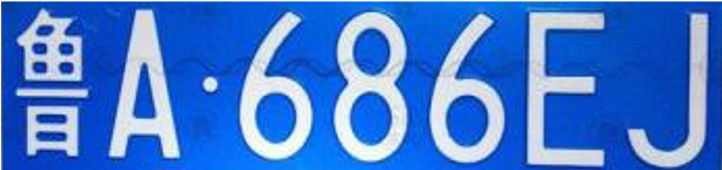


车牌识别结果为：鲁A686EJ

In [39]:
#构建预测动态图过程
with fluid.dygraph.guard():
    model=MyLeNet(channels=1, fig_size=20, num_class=65)#模型实例化
    model_dict,_=fluid.load_dygraph('MyLeNet')
    model.load_dict(model_dict)#加载模型参数
    model.eval()#评估模式
    lab=[]
    for i in range(8):
        if i==2:
            continue
        infer_imgs = []
        infer_imgs.append(load_image('./' + str(i) + '.png'))
        infer_imgs = np.array(infer_imgs)
        infer_imgs = fluid.dygraph.to_variable(infer_imgs)
        result=model(infer_imgs)
        lab.append(np.argmax(result.numpy()))
# print(lab)


display(Image.open('./车牌.png'))
print('\n车牌识别结果为：',end='')
for i in range(len(lab)):
    print(LABEL[str(lab[i])],end='')


请点击[此处](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576)查看本环境基本用法.  <br>
Please click [here ](https://ai.baidu.com/docs#/AIStudio_Project_Notebook/a38e5576) for more detailed instructions. 